# Developing a Flower Image Classifier

In [1]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from collections import OrderedDict 
import torchvision

## Load the data
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# the validation transforms
valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
# training dataset
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# test_dataset
test_data = datasets.ImageFolder(test_dir, transform=valid_transforms)

# validation dataset
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# training data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# test data loaders
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

# validation data loaders
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64)

### Label mapping

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

In [31]:
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    

In [32]:
# TODO: Build and train your network
model.classifier = nn.Sequential(
                        nn.Linear(25088, 512), 
                        nn.ReLU(),
                        nn.Dropout(p=0.2),
    
                        nn.Linear(512, 256),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),
                                 
                        nn.Linear(256, 102),
                        nn.LogSoftmax(dim=1))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [33]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [34]:
epochs = 5
print_every = 5
steps = 0
loss_show = []

for e in range(epochs):
    running_loss = 0
    for inputs, labels in train_loader:
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            valid_loss = 0
            accuracy = 0
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    log_ps = model.forward(inputs)
                    batch_loss = criterion(log_ps, labels)
                    valid_loss += batch_loss.item()
                    
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            print(f"Epoch {e+1}/{epochs}.. "
                  f"Loss: {running_loss/print_every:.3f}.. "
                  f"Validation Loss: {valid_loss/len(valid_loader):.3f}.. "
                  f"Accuracy: {accuracy/len(valid_loader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/5.. Loss: 4.627.. Validation Loss: 4.328.. Accuracy: 0.083
Epoch 1/5.. Loss: 4.361.. Validation Loss: 4.044.. Accuracy: 0.143
Epoch 1/5.. Loss: 4.107.. Validation Loss: 3.716.. Accuracy: 0.221
Epoch 1/5.. Loss: 3.937.. Validation Loss: 3.400.. Accuracy: 0.298
Epoch 1/5.. Loss: 3.683.. Validation Loss: 3.100.. Accuracy: 0.328
Epoch 1/5.. Loss: 3.434.. Validation Loss: 2.840.. Accuracy: 0.371
Epoch 1/5.. Loss: 3.363.. Validation Loss: 2.604.. Accuracy: 0.418
Epoch 1/5.. Loss: 3.107.. Validation Loss: 2.354.. Accuracy: 0.450
Epoch 1/5.. Loss: 2.835.. Validation Loss: 2.158.. Accuracy: 0.475
Epoch 1/5.. Loss: 2.673.. Validation Loss: 1.994.. Accuracy: 0.491
Epoch 1/5.. Loss: 2.607.. Validation Loss: 1.787.. Accuracy: 0.544
Epoch 1/5.. Loss: 2.386.. Validation Loss: 1.666.. Accuracy: 0.566
Epoch 1/5.. Loss: 2.315.. Validation Loss: 1.558.. Accuracy: 0.575
Epoch 1/5.. Loss: 2.191.. Validation Loss: 1.519.. Accuracy: 0.598
Epoch 1/5.. Loss: 1.988.. Validation Loss: 1.339.. Accuracy: 0

## Testing the network

In [40]:
# TODO: Do validation on the test set
test_loss = 0
accuracy = 0
criterion = nn.NLLLoss()
model.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        log_ps = model.forward(inputs)
        batch_loss = criterion(log_ps, labels)
                    
        test_loss += batch_loss.item()
                    
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
print(f"Test accuracy: {accuracy/len(test_loader):.3f}")

Test accuracy: 0.838


## Save the checkpoint

In [36]:
image_datasets = {'train': train_data,
                  'valid': valid_data,
                  'test': test_data}

model.class_to_idx = image_datasets['train'].class_to_idx

In [37]:
# TODO: Save the checkpoint
# Additional information
EPOCH = epochs
PATH = "model.pth"

torch.save({
            'epoch': EPOCH,
            'model': model,
            'class_to_idx': model.class_to_idx,
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

## Loading the checkpoint

In [38]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(path):
    checkpoint = torch.load(path)
    model = checkpoint['model']
    optimizer = checkpoint['optimizer_state_dict']
    epoch = checkpoint['epoch']
    class_to_idx = checkpoint['class_to_idx']

    return model.eval()

In [39]:
path = 'model_4.pth'
model = load_checkpoint(path)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

In [41]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    width = 256
    height = 256
    img = Image.open(image).resize((width, height))
    
    process = transforms.Compose([transforms.CenterCrop(224), 
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                 ])
    
    img = process(img)
    
    return img

In [42]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

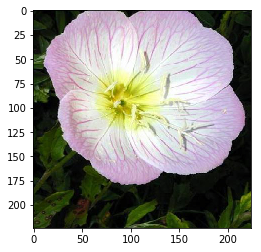

In [43]:
image_path = './flowers/test/1/image_06743.jpg'
imshow(process_image(image_path))

## Class Prediction

In [83]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.to(device)
    model.eval()
    img = process_image(image_path).numpy()
    img = torch.from_numpy(np.array([img])).float()

    with torch.no_grad():
        logps = model.forward(img.to(device))
        
    probability = torch.exp(logps)
    
    probs, classes = probability.topk(topk)
    probs = probs.cpu().numpy()[0]
    classes = classes.cpu().numpy()[0]
    
    class_to_idx = {value:key for key, value in model.class_to_idx.items()}
    classes = [class_to_idx[idx] for idx in classes]
    
    return probs, classes

In [84]:
probs, classes = predict('./flowers/test/1/image_06743.jpg', model)
print(probs)
print(classes)

[  9.93198693e-01   5.49471518e-03   7.57560832e-04   2.21337250e-04
   1.96723660e-04]
['1', '51', '83', '86', '97']


## Sanity Checking

In [132]:
def check_sanity(image_path, model):
    probs, classes = predict(image_path, model)
    flower_labels = [cat_to_name[str(i)] for i in classes]
    predicted_flower_label = flower_labels[np.argmax(probs)]
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
    img = Image.open(image_path)
    ax1.axis('off')
    ax1.set_title(predicted_flower_label)
    ax1.imshow(img)
    
    # Probability bar chart
    y_pos = np.arange(len(flower_labels))
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(flower_labels)
    ax2.barh(y_pos, probs, align = 'center')
    
    plt.show()
    

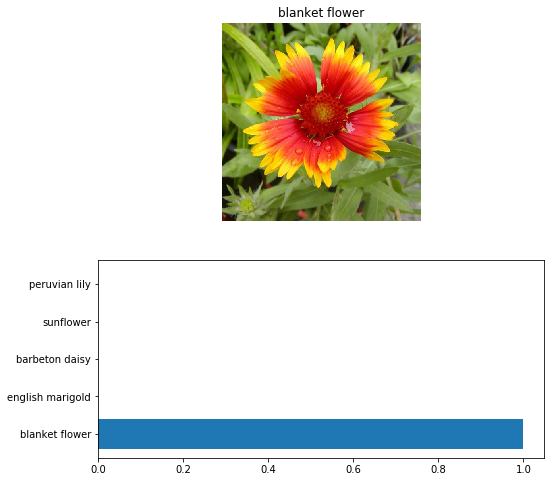

In [134]:
# TODO: Display an image along with the top 5 classes
image_path = './flowers/test/100/image_07899.jpg'
check_sanity(image_path, model)